In [2]:
import sqlite3 
from sqlite3 import Error 

import pandas as pd

pd.set_option('display.max_columns', None)

Необходимо скачать CSV-файл — [«final_transactions.csv»](https://drive.google.com/file/d/1_YrZPaD1zNCcXUkUfeWM0ZOdg_was_iA/view), создать таблицу transaction_bd со всеми полями, загрузить данные из файла в таблицу и оставить таблицу со структурой:

* (0, 'TX_DATETIME', 'NUMERIC', 0, None, 0) - время транзакций
* (1, 'CUSTOMER_ID', 'INTEGER', 0, None, 0) - клиент
* (2, 'TX_AMOUNT', 'REAL', 0, None, 0) - сумма транзакций

***Комментарий***: Можно оставить все 5 полей, но запросы будут выполняться чуть дольше.

In [3]:
data = pd.read_csv('final_transactions.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   TRANSACTION_ID  1048575 non-null  int64  
 1   TX_DATETIME     1048575 non-null  object 
 2   CUSTOMER_ID     1048575 non-null  int64  
 3   TERMINAL_ID     1048575 non-null  int64  
 4   TX_AMOUNT       1048575 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 40.0+ MB


In [5]:
def create_connection(path):

    """
    Функция подключения к базе данных
    """

    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [6]:
def execute_query(connection, query):

    """
    Функция выполнения запроса к базе данных
    """

    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

In [79]:
def sql_insert(connection, data, name, m=0, n=data.shape[1]):

    """
    Функция для добавления значений в таблицу
    """

    cursor = connection.cursor()
    try:
        cursor.executemany(f"""
                INSERT INTO {name} {tuple(data.columns[m:n])} 
                    VALUES ({str("?, " * (n-m-1) + "?")})""",
                data.iloc[:, m:n].values)
        connection.commit()
    except Error as e:
        print(f"The error '{e}' occurred")

In [7]:
# Подключаюсь к базе данных (если нет такой, то создается)
connection = create_connection("HW_2.db")

Connection to SQLite DB successful


In [83]:
# Код для создания таблицы
create_users_table = """
    CREATE TABLE IF NOT EXISTS transaction_tbl (
        transaction_id INTEGER PRIMARY KEY AUTOINCREMENT,
        tx_datetime NUMERIC NOT NULL,
        customer_id INTEGER NOT NULL,
        terminal_id INTEGER NOT NULL,
        tx_amount REAL NOT NULL
    );
    """

# Создание таблицы через функцию
execute_query(connection, create_users_table)

Query executed successfully


In [80]:
# Вставка данных в таблицу
sql_insert(connection, data, 'transaction_tbl')

In [84]:
pd.read_sql('SELECT * FROM transaction_tbl', connection)

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount
0,0,2023-01-01 00:00:31,596,3156,533.07
1,1,2023-01-01 00:02:10,4961,3412,808.56
2,2,2023-01-01 00:07:56,2,1365,1442.94
3,3,2023-01-01 00:09:29,4128,8737,620.65
4,4,2023-01-01 00:10:34,927,9906,490.66
...,...,...,...,...,...
1048570,1048570,2023-04-20 10:07:13,2380,3780,325.64
1048571,1048571,2023-04-20 10:07:28,738,5151,20.38
1048572,1048572,2023-04-20 10:07:33,1000,5417,182.79
1048573,1048573,2023-04-20 10:07:39,3028,6439,455.44


A. Вывести всех клиентов, у которых сумма транзакций больше 700000 за весь период (сортируя клиентов по возрастанию);

In [108]:
pd.read_sql("""
    SELECT 
        customer_id,
        SUM(tx_amount) as tx_sum
    FROM 
        transaction_tbl
    GROUP BY
        customer_id
    HAVING
        SUM(tx_amount) > 700000
    ORDER BY
        customer_id
    """, connection)

,customer_id,tx_sum
0,389,753411.90
1,2249,707478.64
2,2891,786115.87
3,3116,721980.69
4,4163,765153.63


B. Вывести всех клиентов, у которых сумма транзакций больше 200000 за период 01.01.2023 - 13.01.2023 (сортируя клиентов по возрастанию);

In [107]:
pd.read_sql("""
    SELECT 
        customer_id,
        SUM(tx_amount) as tx_sum
    FROM 
        transaction_tbl
    WHERE
        date(tx_datetime) BETWEEN '2023-01-01' AND '2023-01-13'
    GROUP BY
        customer_id
    HAVING
        SUM(tx_amount) > 200000
    ORDER BY
        customer_id
    """, connection)

,customer_id,tx_sum
0,1918,241299.96
1,3406,207733.48
2,3833,269107.40
3,4252,220650.36


C. Вывести тех клиентов, у которых id начинается с 4 и количество транзакций за весь период более 444;

In [109]:
pd.read_sql("""
    SELECT 
        customer_id,
        COUNT(transaction_id) as tx_cnt
    FROM 
        transaction_tbl
    WHERE
        customer_id LIKE '4%'
    GROUP BY
        customer_id
    HAVING
        COUNT(transaction_id) > 444
    ORDER BY
        customer_id
    """, connection)

,customer_id,tx_cnt
0,4231,451
1,4539,445
2,4661,449


D. Создать флаг доходности клиентов по логике:
1. Если сумма транзакций не более 50000, тогда вывести 'низкая доходность';
2. Если сумма транзакций больше 50000 и не более 10000 тогда вывести 'средняя доходность';
3. Если сумма транзакций больше 100000 тогда вывести 'высокая доходность'.

In [112]:
pd.read_sql("""
    SELECT 
        customer_id,
        SUM(tx_amount) AS tx_sum,
        CASE
            WHEN SUM(tx_amount) <= 50000 
                THEN 'low'
            WHEN SUM(tx_amount) > 100000 
                THEN 'high'
            ELSE 'middle'
        END AS income_lvl
    FROM 
        transaction_tbl
    GROUP BY
        customer_id
    ORDER BY
        customer_id
    """, connection)

,customer_id,tx_sum,income_lvl
0,0,119568.47,high
1,1,323510.82,high
2,2,162541.90,high
3,3,2406.56,low
4,4,300589.33,high
...,...,...,...
4981,4995,149962.31,high
4982,4996,27135.67,low
4983,4997,131288.62,high
4984,4998,337988.39,high


E. Посмотреть количество клиентов с каждым видом доходности (из пункта 2.d);

In [114]:
pd.read_sql("""
    SELECT
        income_lvl, 
        COUNT(customer_id) AS cust_cnt
    FROM (
        SELECT 
            customer_id,
            SUM(tx_amount) AS sum_amnt,
            CASE
                WHEN SUM(tx_amount) <= 50000 
                    THEN 'low'
                WHEN SUM(tx_amount) > 100000 
                    THEN 'high'
                ELSE 'middle'
            END AS income_lvl
        FROM 
            transaction_tbl
        GROUP BY
            customer_id
        ORDER BY
            customer_id
    )
    GROUP BY
        income_lvl
    """, connection)

,income_lvl,cust_cnt
0,high,2167
1,low,1812
2,middle,1007


F. Вывести сумму транзакций за каждый день (сортируя дни по возрастанию).

In [8]:
data_ = pd.read_sql("""
    SELECT 
        date(tx_datetime) AS tx_date,
        SUM(tx_amount) AS tx_sum
    FROM 
        transaction_tbl
    GROUP BY
        date(tx_datetime)
    ORDER BY
        date(tx_datetime)
    """, connection)

display(data_)

DatabaseError: Execution failed on sql '
    SELECT 
        date(tx_datetime) AS tx_date,
        SUM(tx_amount) AS tx_sum
    FROM 
        transaction_tbl
    GROUP BY
        date(tx_datetime)
    ORDER BY
        date(tx_datetime)
    ': no such table: transaction_tbl

Подготовить дашборд с помощью Dash по пункту 2.f, включив туда графики bar и histogram; вставить в конце ноутбука скрин графиков из дашборда.

In [125]:
from dash import Dash, html, dcc
import plotly.express as px
import pandas as pd

app = Dash()

fig1 = px.bar(data_, x="tx_date", y="tx_sum")

fig2 = px.histogram(data_, x="tx_sum", nbins=45, color_discrete_sequence=['indianred'])

app.layout = html.Div(children=[
    html.H1(children='Данные по транзакциям', style={'text-align': 'center'}),
    html.Div(children='Сумма транзакций за каждый день'),

    dcc.Graph(
        id='example-graph',
        figure=fig1
    ),
    
    html.Div(children='Количество дней с диапазоннами сумм по транзакциям'),
    dcc.Graph(
        id='example-graph1',
        figure=fig2
    )
])

app.run_server()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [28/Mar/2023 22:58:01] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2023 22:58:01] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2023 22:58:01] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2023 22:58:01] "GET /_favicon.ico?v=2.9.1 HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2023 22:58:01] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2023 22:58:01] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -


In [126]:
connection.close()

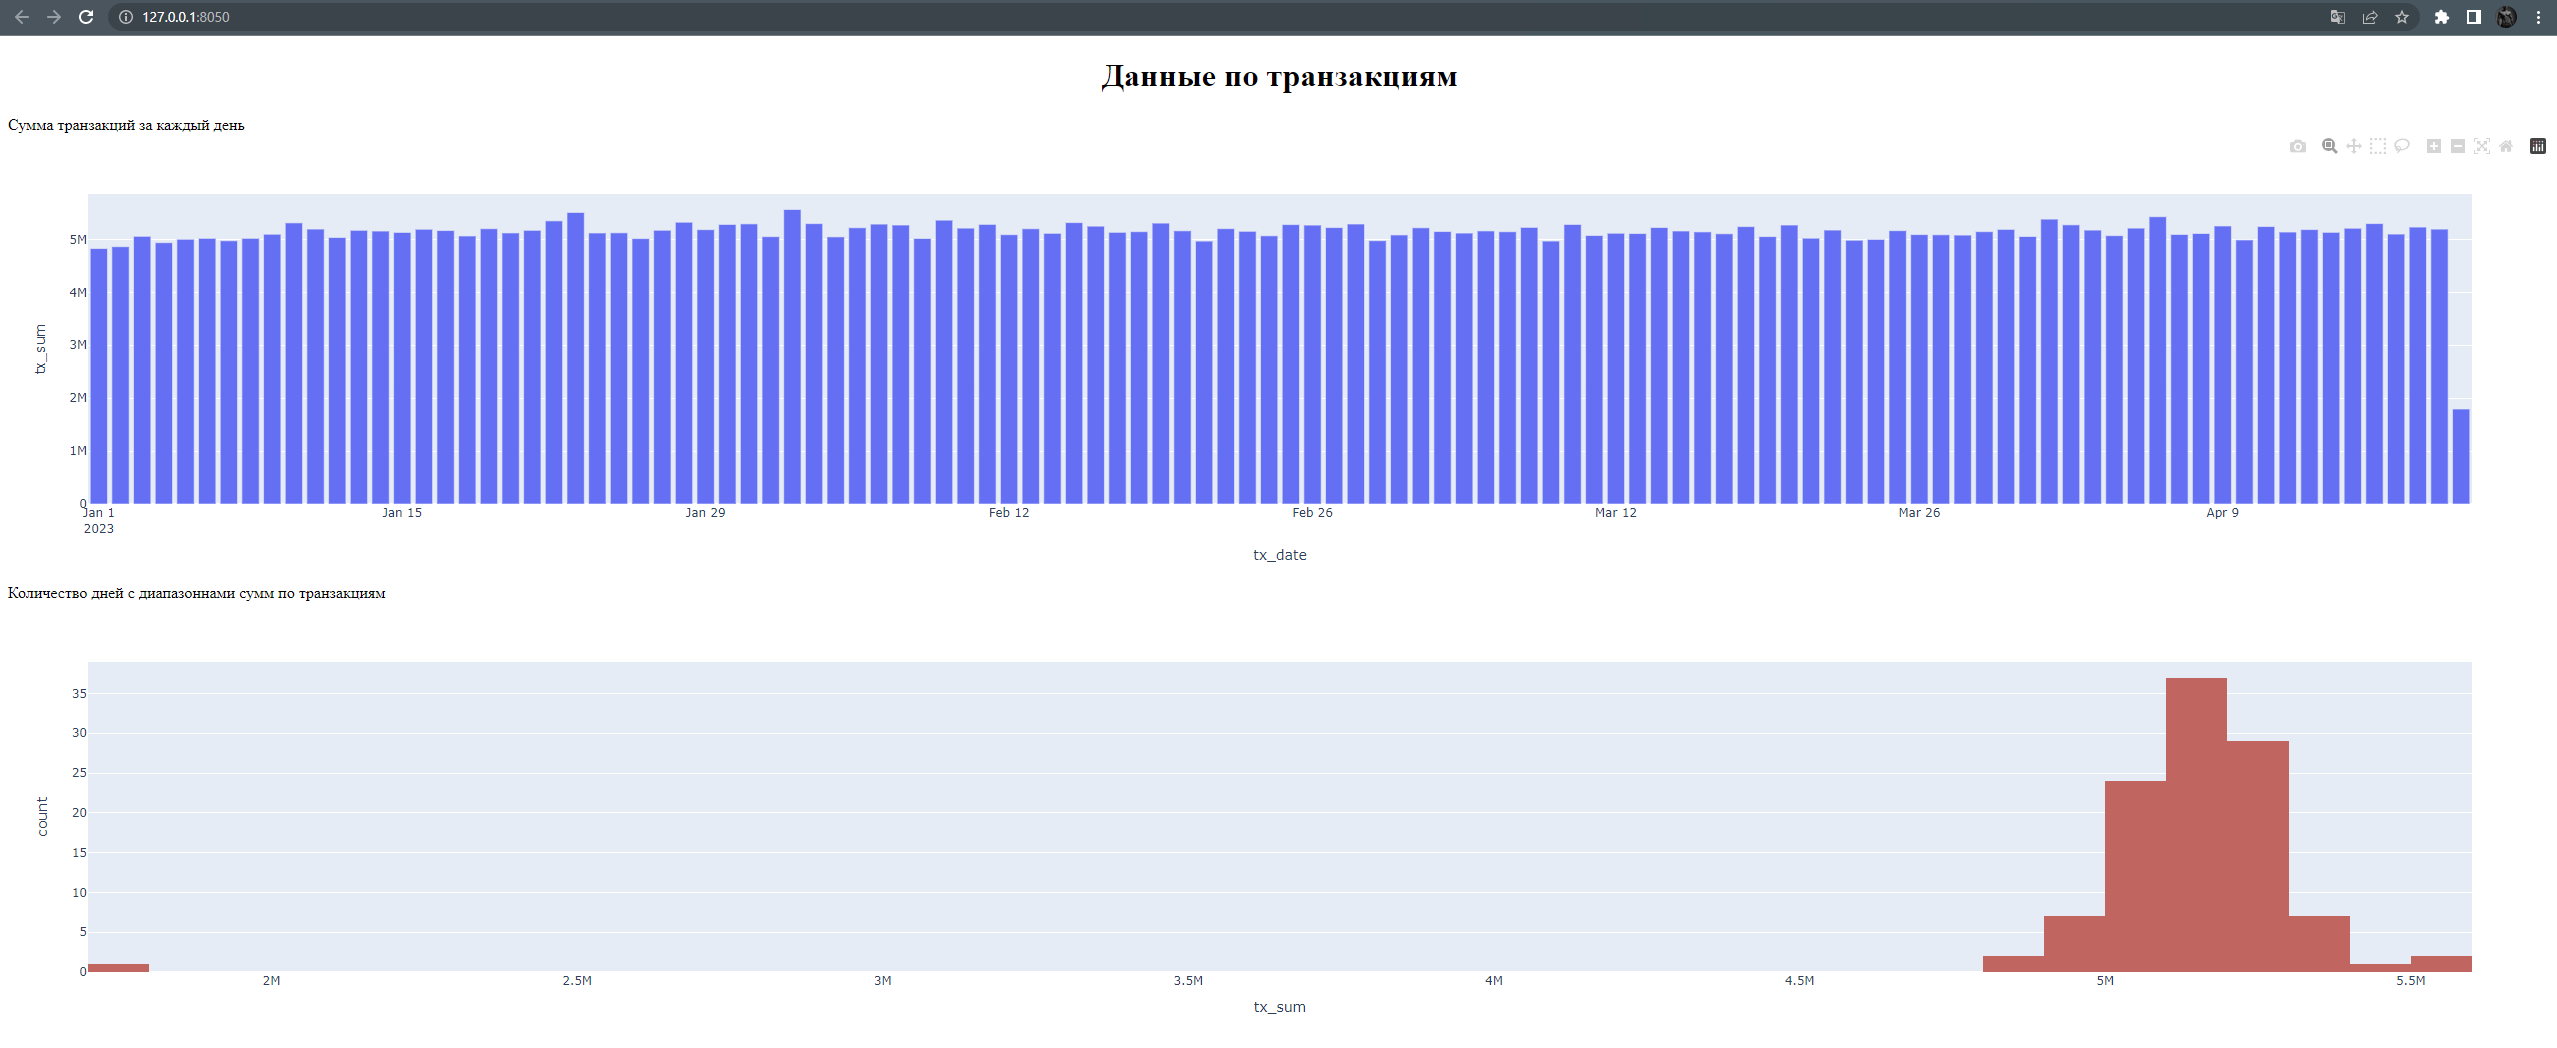